### "Euphotic zone residence time of Antarctic Bottom Water"

### Code for Visualizing the Euphotic Zone Residence Locations 

Used for generating Figure S3

Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

(Note that this script is based on "Main_Figure2_Residence_loc_map.ipynb")

In [1]:
# Define the threshld for euphotic zone PAR in (watts per square metres)
# 2  mol/m^2/day: 5.439369304008213
# 3  mol/m^2/day: 8.15905395601232
# 4  mol/m^2/day: 10.878738608016427
PARZ_thre = 8.159
PARZ_thre_L = 5.439
PARZ_thre_U = 10.879

In [2]:
# Importing the relevant modules. 
import numpy as np
import xarray as xr
import math
import time
import datetime as dt
from datetime import timedelta
import calendar
import os
import re
from glob import glob
#
import netCDF4 as nc
import pandas as pd
import gsw
#
import cartopy.crs as ccrs
from scipy.io import loadmat
#
import matplotlib.pyplot as plt
import matplotlib.colors as col

#
import cosima_cookbook as cc
#session =cc.database.create_session('cosima_master_2022-08-30.db')
session =cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'
#
from os import sys
sys.path.append('/home/581/yx9454/PhD_Ch1')
from My_Py_Func import Ch1_defs as c1d

import pygamma

In [3]:
# In each experiment, we define 06-18, release-06, 05-release, 87-05,
# loop_start_point-87 (if availiable) as No 0,1,2,3,4(if availiable)

master_path = '/g/data/jk72/yx9454/runs/parcels/output_after_Aug/'
traj_input = {'MLS_ON':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_Loop_MLS_ON/'}],
              'MLS_OFF':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_OFF/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_OFF/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=5day)_Jan-Dec_MLS_OFF/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=5days)_Following_MLS_OFF/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=5days)_Following_Loop_MLS_OFF/'}],
              'MLS_Weak':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON_middle_forw/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON_middle_forw/'},
                          {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON_middle_back/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON_middle_back/'},
                        ]
        }

# Load necessary files

In [15]:
%%time
exp_name = 'MLS_ON'

# Load traj files 0
# From 5days freq npz file
var_in_arrs_0 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_0.npz')
var_in_arrs_0['x']   =npzfile['x']
var_in_arrs_0['y']   =npzfile['y']
var_in_arrs_0['timeshort'] = npzfile['time']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_0_CS_Eu_date.npz')
var_in_arrs_0['CS_Eu_date']=npzfile['CS_Eu_date']

# Load traj files 1
# From 5days freq npz file
var_in_arrs_1 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_1.npz')
var_in_arrs_1['x']   =npzfile['x']
var_in_arrs_1['y']   =npzfile['y']
var_in_arrs_1['timeshort'] = npzfile['time']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_1_CS_Eu_date.npz')
var_in_arrs_1['CS_Eu_date']=npzfile['CS_Eu_date']

# Load traj files 3
# From 5days freq npz file
var_in_arrs_3 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_3_5days_freq.npz')
var_in_arrs_3['x']   =npzfile['x']
var_in_arrs_3['y']   =npzfile['y']
var_in_arrs_3['timeshort'] = npzfile['time']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_3_5days_freq_CS_Eu_date.npz')
var_in_arrs_3['CS_Eu_date']=npzfile['CS_Eu_date']

# Manually reset
traj_input[exp_name][3]['out_freq'] = 5

# Load traj files 2
# From 5days freq npz file
var_in_arrs_2 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_2_5days_freq.npz')
var_in_arrs_2['x']   =npzfile['x']
var_in_arrs_2['y']   =npzfile['y']
var_in_arrs_2['timeshort'] = npzfile['time']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_2_5days_freq_CS_Eu_date.npz')
var_in_arrs_2['CS_Eu_date']=npzfile['CS_Eu_date']

# Manually reset
traj_input[exp_name][2]['out_freq'] = 5

# Load traj files 4
# From 5days freq npz file
var_in_arrs_4 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_4_5days_freq.npz')
var_in_arrs_4['x']   =npzfile['x']
var_in_arrs_4['y']   =npzfile['y']
var_in_arrs_4['timeshort'] = npzfile['time']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_4_5days_freq_CS_Eu_date.npz')
var_in_arrs_4['CS_Eu_date']=npzfile['CS_Eu_date']

# Manually reset
traj_input[exp_name][4]['out_freq'] = 5

CPU times: user 1min 48s, sys: 1min 56s, total: 3min 44s
Wall time: 3min 53s


In [24]:
%%time
# Load traj files 0
# From 5days freq npz file
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_0.npz')
var_in_arrs_0['z']   =npzfile['z']

# Load traj files 1
# From 5days freq npz file
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_1.npz')
var_in_arrs_1['z']   =npzfile['z']

# Load traj files 3
# From 5days freq npz file
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_3_5days_freq.npz')
var_in_arrs_3['z']   =npzfile['z']

# Load traj files 2
# From 5days freq npz file
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_2_5days_freq.npz')
var_in_arrs_2['z']   =npzfile['z']

# Load traj files 4
# From 5days freq npz file
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_4_5days_freq.npz')
var_in_arrs_4['z']   =npzfile['z']

CPU times: user 34.8 s, sys: 31.7 s, total: 1min 6s
Wall time: 1min 8s


In [16]:
exp_name = 'MLS_ON'
AABW_inds = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/AABW_inds.npz')['AABW_inds']

stopsign_list = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/stopsign_list_for_20yrs_150m_thre.npz')['stopsign_list']
CDW_inds = ~(np.isnan(stopsign_list))
AABW_shallower_than_EZD_plus_CDW =  (var_in_arrs_0['CS_Eu_date'][:,-1]>0) & (CDW_inds)

In [17]:
print('AABW: ',sum(AABW_inds))
print('AABW_CDW: ',sum(CDW_inds))
print('AABW&EZD: ',sum(var_in_arrs_0['CS_Eu_date'][:,-1]>0))
print('AABW&cdw&EZD: ',sum(AABW_shallower_than_EZD_plus_CDW))

AABW:  94123
AABW_CDW:  88809
AABW&EZD:  30950
AABW&cdw&EZD:  26733


# Density Analysis

In [ ]:
# Subset that following analysis will base on
For_AABW_CDW_only  =True

### Load the datetime

In [18]:
var_in_arrs_s = [var_in_arrs_4,var_in_arrs_3,var_in_arrs_2,var_in_arrs_1,var_in_arrs_0]

i=0
for name in ['var_in_arrs_4','var_in_arrs_3','var_in_arrs_2','var_in_arrs_1','var_in_arrs_0']:
    npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/MLS_ON/'+name+'_datetime.npz'
                     ,allow_pickle=True)
    var_in_arrs_s[i]['datetime'] = npzfile['datetime']
    i+=1


In [19]:
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/MLS_ON/gamma_all.npz',allow_pickle=True)
gamma_all_here = npzfile['gamma_all_here']
dates_all      = npzfile['dates_all']

In [20]:
#
p_0_100_array = []
for i in np.arange(len(dates_all)):
    p_0_100 = [np.nanmin(gamma_all_here[:,i])]
    for percentile in np.arange(5,99,5):
        p_0_100.append(np.nanpercentile(gamma_all_here[:,i],percentile))
    p_0_100.append(np.nanmax(gamma_all_here[:,i]))
    p_0_100_array.append(p_0_100)
p_0_100_array = np.array(p_0_100_array).T

if For_AABW_CDW_only:
    p_0_100_array = []
    for i in np.arange(len(dates_all)):
        p_0_100 = [np.nanmin(gamma_all_here[AABW_shallower_than_EZD_plus_CDW][:,i])]
        for percentile in np.arange(5,99,5):
            p_0_100.append(np.nanpercentile(gamma_all_here[AABW_shallower_than_EZD_plus_CDW][:,i],percentile))
        p_0_100.append(np.nanmax(gamma_all_here[AABW_shallower_than_EZD_plus_CDW][:,i]))
        p_0_100_array.append(p_0_100)
    p_0_100_array = np.array(p_0_100_array).T

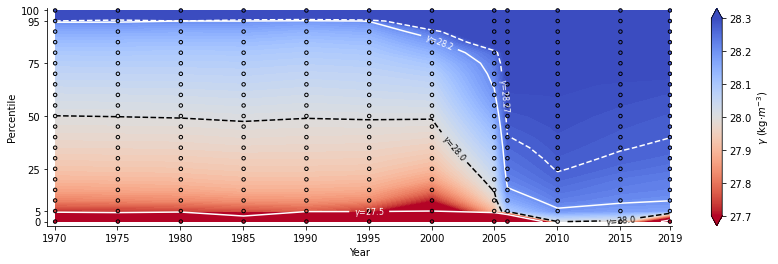

In [22]:
import matplotlib.dates as mdates
plt.figure(figsize=(14,4))
plt.contourf(dates_all,np.arange(0,101,5),p_0_100_array,levels=np.arange(20,45,0.01),vmin=27.7,vmax=28.3,cmap='coolwarm_r')  #RdYlBu
X,Y = np.meshgrid(dates_all,np.arange(0,101,5))
plt.scatter(X,Y,c=p_0_100_array,vmin=27.7,vmax=28.3,cmap='coolwarm_r', edgecolors='black',s=12,zorder=11)
cbar = plt.colorbar(label='$\gamma$ (kg$\cdot m^{-3}$)',extend='both')

cs0=plt.contour(dates_all,np.arange(0,101,5),p_0_100_array,linestyles='-',colors='w',levels=[27.5],zorder=10)
fmt = {27.5: '$\gamma$=27.5'}
plt.clabel(cs0, cs0.levels, inline=True, fmt=fmt, fontsize=8)

cs=plt.contour(dates_all,np.arange(0,101,5),p_0_100_array,linestyles='--',colors='w',levels=[28.27],zorder=10)
# Add inline labels to contour lines
# Assign inline texts to contour levels
fmt = {28.27: '$\gamma$=28.27'}
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=8)

cs3=plt.contour(dates_all,np.arange(0,101,5),p_0_100_array,linestyles='-',colors='w',levels=[28.2],zorder=10)
# Add inline labels to contour lines
# Assign inline texts to contour levels
fmt = {28.2: '$\gamma$=28.2'}
plt.clabel(cs3, cs3.levels, inline=True, fmt=fmt, fontsize=8)

cs2=plt.contour(dates_all,np.arange(0,101,5),p_0_100_array,linestyles='--',colors='k',levels=[28.0],zorder=10)
fmt = {28.0: '$\gamma$=28.0'}
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=8)
plt.ylim(-2,101)
plt.xlim(dt.datetime(1969,6,1),dt.datetime(2019,3,1))
plt.yticks([0,5,25,50,75,95,100])  # specify y-ticks
xticks=[]
for yyyy in [1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2019]:
    xticks.append(dt.datetime(yyyy,1,1))
plt.xticks(xticks)
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.grid(linestyle='-',color='w',axis='y',zorder=1)  # add horizontal grid lines
plt.xlabel('Year')
plt.ylabel('Percentile')

# Remove the upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if For_AABW_CDW_only:
    plt.savefig('Review_Percentile_Gamma_AABW_CDW_pts.png',dpi=500)
else:
    plt.savefig('Review_Percentile_Gamma_AABW_pts.png',dpi=500)

### Similar analysis but for depth

In [25]:
inds_here = AABW_inds

var_in_arrs_s = [var_in_arrs_4,var_in_arrs_3,var_in_arrs_0]
years = [[1970,1975,1980,1985],[1990,1995,2000,2005],[2006,2010,2015,2020]]
z_analysis=[]
dates_all =[]
for i in np.arange(3):
    var_in_arrs = var_in_arrs_s[i]
    
    # Get the time inds
    time_inds    = []
    target_dates = []
    for yyyy in years[i]:
        target_date = dt.datetime(yyyy,1,15)
        if yyyy == 2005:
            target_date = dt.datetime(yyyy,12,27)
        
        target_dates.append(target_date) 

        # Calculate the absolute differences between the array values and the target date
        differences = np.abs(var_in_arrs['datetime'] - target_date)
        # Find the index of the closest value
        closest_index = np.argmin(differences)
        time_inds.append(closest_index)

    time_inds = np.array(time_inds)
    print('Z Calculation Start')
    print(var_in_arrs['datetime'][time_inds])
    
    for ind in time_inds:
        
        if For_AABW_CDW_only:
            z_analysis.append(var_in_arrs['z'][inds_here][AABW_shallower_than_EZD_plus_CDW][:,ind])
        else:
            z_analysis.append(var_in_arrs['z'][inds_here][:,ind])
            
        dates_all.append(var_in_arrs['datetime'][ind])
z_analysis = np.array(z_analysis).T
z_analysis[z_analysis>10000]=np.nan

Z Calculation Start
[datetime.datetime(1970, 1, 14, 0, 0) datetime.datetime(1975, 1, 13, 0, 0)
 datetime.datetime(1980, 1, 17, 0, 0) datetime.datetime(1985, 1, 15, 0, 0)]
Z Calculation Start
[datetime.datetime(1990, 1, 15, 0, 0) datetime.datetime(1995, 1, 14, 0, 0)
 datetime.datetime(2000, 1, 13, 0, 0) datetime.datetime(2005, 1, 1, 0, 0)]
Z Calculation Start
[datetime.datetime(2006, 1, 16, 0, 0) datetime.datetime(2010, 1, 15, 0, 0)
 datetime.datetime(2015, 1, 14, 0, 0)
 datetime.datetime(2018, 12, 24, 0, 0)]


In [26]:
#gamma_all_here = np.array(gamma_all).T
#gamma_all_here[gamma_all_here<=0] = np.nan
p_0_100_array_z = []
for i in np.arange(z_analysis.shape[1]):
    p_0_100 = [np.nanmin(z_analysis[:,i])]
    for percentile in np.arange(5,99,5):
        p_0_100.append(np.nanpercentile(z_analysis[:,i],percentile))
    p_0_100.append(np.nanmax(z_analysis[:,i]))
    p_0_100_array_z.append(p_0_100)
p_0_100_array_z = np.array(p_0_100_array_z).T

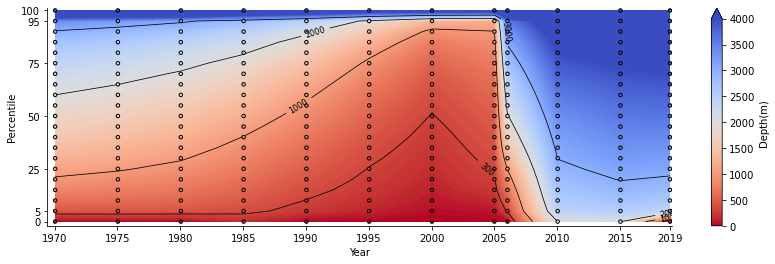

In [27]:
import matplotlib.dates as mdates
plt.figure(figsize=(14,4))
plt.contourf(dates_all,np.arange(0,101,5),p_0_100_array_z,levels=np.arange(0,6501,25),vmin=0,vmax=4000,cmap='coolwarm_r')  #RdYlBu

X,Y = np.meshgrid(dates_all,np.arange(0,101,5))
plt.scatter(X,Y,c=p_0_100_array_z,vmin=0,vmax=4000,cmap='coolwarm_r', edgecolors='black',s=12,zorder=11)
plt.colorbar(label='Depth(m)',extend='max')
cs = plt.contour(dates_all,np.arange(0,101,5),p_0_100_array_z,linestyles='-',colors='k',levels=[300,1000,2000,3000],zorder=10,linewidths=0.75)
# Add inline labels to contour lines
plt.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)
#plt.contour(dates_all,np.arange(0,101,5),p_0_100_array,linestyles='--',colors='k',levels=[28.0],zorder=10)
#plt.legend()
plt.ylim(-2,101)
plt.xlim(dt.datetime(1969,6,1),dt.datetime(2019,3,1))
plt.yticks([0,5,25,50,75,95,100])  # specify y-ticks
xticks=[]
for yyyy in [1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2019]:
    xticks.append(dt.datetime(yyyy,1,1))
plt.xticks(xticks)
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.grid(linestyle='-',color='w',axis='y',zorder=1)  # add horizontal grid lines
plt.xlabel('Year')
plt.ylabel('Percentile')
# Remove the upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
if For_AABW_CDW_only:
    plt.savefig('Review_Percentile_Depth_AABW_CDW_pts.png',dpi=500)
else:
    plt.savefig('Review_Percentile_Depth_AABW_pts.png',dpi=500)

### Similar analysis but for lat

In [28]:
inds_here = AABW_inds

var_in_arrs_s = [var_in_arrs_4,var_in_arrs_3,var_in_arrs_0]
years = [[1970,1975,1980,1985],[1990,1995,2000,2005],[2006,2010,2015,2020]]
y_analysis=[]
dates_all =[]
for i in np.arange(3):
    var_in_arrs = var_in_arrs_s[i]
    
    # Get the time inds
    time_inds    = []
    target_dates = []
    for yyyy in years[i]:
        target_date = dt.datetime(yyyy,1,15)
        if yyyy == 2005:
            target_date = dt.datetime(yyyy,12,27)
        
        target_dates.append(target_date) 

        # Calculate the absolute differences between the array values and the target date
        differences = np.abs(var_in_arrs['datetime'] - target_date)
        # Find the index of the closest value
        closest_index = np.argmin(differences)
        time_inds.append(closest_index)

    time_inds = np.array(time_inds)
    print('Y Calculation Start')
    print(var_in_arrs['datetime'][time_inds])
    
    for ind in time_inds:
        
        if For_AABW_CDW_only:
            y_analysis.append(var_in_arrs['y'][inds_here][AABW_shallower_than_EZD_plus_CDW][:,ind])
        else:
            y_analysis.append(var_in_arrs['y'][inds_here][:,ind])
        dates_all.append(var_in_arrs['datetime'][ind])

y_analysis = np.array(y_analysis).T
y_analysis[y_analysis>90] = np.nan

Y Calculation Start
[datetime.datetime(1970, 1, 14, 0, 0) datetime.datetime(1975, 1, 13, 0, 0)
 datetime.datetime(1980, 1, 17, 0, 0) datetime.datetime(1985, 1, 15, 0, 0)]
Y Calculation Start
[datetime.datetime(1990, 1, 15, 0, 0) datetime.datetime(1995, 1, 14, 0, 0)
 datetime.datetime(2000, 1, 13, 0, 0) datetime.datetime(2005, 1, 1, 0, 0)]
Y Calculation Start
[datetime.datetime(2006, 1, 16, 0, 0) datetime.datetime(2010, 1, 15, 0, 0)
 datetime.datetime(2015, 1, 14, 0, 0)
 datetime.datetime(2018, 12, 24, 0, 0)]


In [29]:
#gamma_all_here = np.array(gamma_all).T
#gamma_all_here[gamma_all_here<=0] = np.nan
p_0_100_array_y = []
for i in np.arange(y_analysis.shape[1]):
    p_0_100 = [np.nanmin(y_analysis[:,i])]
    for percentile in np.arange(5,99,5):
        p_0_100.append(np.nanpercentile(y_analysis[:,i],percentile))
    p_0_100.append(np.nanmax(y_analysis[:,i]))
    p_0_100_array_y.append(p_0_100)
p_0_100_array_y = np.array(p_0_100_array_y).T
p_0_100_array_y = p_0_100_array_y*-1

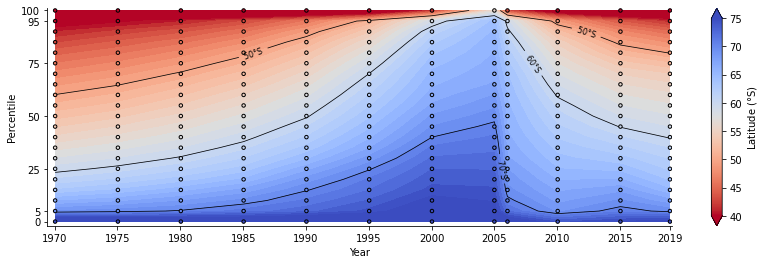

In [30]:
import matplotlib.dates as mdates
plt.figure(figsize=(14,4))
plt.contourf(dates_all,np.arange(0,101,5),p_0_100_array_y,levels=np.arange(25,90),vmin=40,vmax=75,cmap='coolwarm_r')  #RdYlBu

X,Y = np.meshgrid(dates_all,np.arange(0,101,5))
plt.scatter(X,Y,c=p_0_100_array_y,vmin=40,vmax=75,cmap='coolwarm_r', edgecolors='black',s=12,zorder=11)
plt.colorbar(label='Latitude ($\degree$S)',extend='both')
cs = plt.contour(dates_all,np.arange(0,101,5),p_0_100_array_y,linestyles='-',colors='k',levels=[50,60,70],zorder=10,linewidths=0.75)
# Add inline labels to contour lines
# Assign inline texts to contour levels
fmt = {50: '50$\degree$S', 60: '60$\degree$S', 70: '70$\degree$S'}
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=8)

plt.ylim(-2,101)
plt.xlim(dt.datetime(1969,6,1),dt.datetime(2019,3,1))
plt.yticks([0,5,25,50,75,95,100])  # specify y-ticks
xticks=[]
for yyyy in [1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2019]:
    xticks.append(dt.datetime(yyyy,1,1))
plt.xticks(xticks)
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.grid(linestyle='-',color='w',axis='y',zorder=1)  # add horizontal grid lines
plt.xlabel('Year')
plt.ylabel('Percentile')
# Remove the upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if For_AABW_CDW_only:
    plt.savefig('Review_Percentile_Latitude_AABW_CDW_pts.png',dpi=500)
else:
    plt.savefig('Review_Percentile_Latitude_AABW_pts.png',dpi=500)